### Option 05 - Fraud Detection for Finance
For this project, import the dataset here, <br/>
https://www.kaggle.com/ntnu-testimon/banksim1 <br>
Alternative link <br/>
https://www.kaggle.com/code/vmeh23/general-data-analysis-for-banksim-data-set/data

* step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). <br/>
* customer: ID of the customer <br/>
* age: The age of the accounts  <br/>
* gender: Gender of the customer <br/>
* zipcodeOri: The zip code of the customer<br/>
* merchant:  ID of the merchant <br/>
* zipMerchant: The zip code of the merchant <br/>
* category: Category of the transaction <br/>
* amount: The amount of the transaction <br/>
* fraud: Binary value indicating fraudulent or not fraudulent <br/>

In [2]:
# (1) Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential


from keras.layers import *

In [3]:
# (2.c) Read transaction data into Pandas DataFrame
fraud_df = pd.read_csv('./bs140513_032310.csv')
fraud_df.head()
fraud_df['fraud'].value_counts()

# Note: the equivalent method for a PySpark DataFrame is
# df = spark.read.csv()

0    587443
1      7200
Name: fraud, dtype: int64

In [4]:
# (3) Explore data (for example, see what is categorial and numerical)
# The dataset has 10 columns out of whish one is dependent variable and 9 independent variables 
# No variable column has null values.
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [5]:
fraud_df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [6]:
fraud_df.rename(columns={'zipcodeOri':'zipCustomer'},inplace=True)
fraud_df.head()


,step,customer,age,gender,zipCustomer,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# Data Cleaning


In [7]:
unique_ages=pd.DataFrame(fraud_df['age'].value_counts())
unique_genders=pd.DataFrame(fraud_df['gender'].value_counts())
unique_zipCustomer=pd.DataFrame(fraud_df['zipCustomer'].value_counts())
unique_zipMerchant=pd.DataFrame(fraud_df['zipMerchant'].value_counts())

print(unique_genders)
print(unique_ages)
print(unique_zipCustomer)
print(unique_zipMerchant)

     gender
'F'  324565
'M'  268385
'E'    1178
'U'     515
        age
'2'  187310
'3'  147131
'4'  109025
'5'   62642
'1'   58131
'6'   26774
'0'    2452
'U'    1178
         zipCustomer
'28007'       594643
         zipMerchant
'28007'       594643


In [8]:
irrelevant_features=['zipCustomer','zipMerchant']
fraud_df.drop(irrelevant_features,axis=1,inplace=True)
fraud_df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


In [9]:
fraud_df['age']=fraud_df['age'].str.replace("'",'')
fraud_df['gender']=fraud_df['gender'].str.replace("'",'')
fraud_df['category']=fraud_df['category'].str.replace("'",'')
fraud_df['gender'].value_counts()

F    324565
M    268385
E      1178
U       515
Name: gender, dtype: int64

In [10]:
# The gender and age columns contain some incorrect values
gender_and_age=fraud_df.loc[fraud_df['age']=='U',['gender','age']].value_counts()
print('The number of rows where gender column equals "E" and age column is "U":',gender_and_age)

The number of rows where gender column equals "E" and age column is "U": gender  age
E       U      1178
dtype: int64


In [11]:
# Rows with incorrect values were dropped
cond1=fraud_df['gender']=='E'
cond2=fraud_df['gender']=='U'

fraud_df=fraud_df.drop(fraud_df[cond1].index,axis=0,inplace=False)
fraud_df=fraud_df.drop(fraud_df[cond2].index,axis=0,inplace=False)

gender_map={'M':0,'F':1}
fraud_df['gender']=fraud_df['gender'].map(gender_map)
print(fraud_df['gender'].value_counts(dropna=False))
print(fraud_df['age'].value_counts(dropna=False))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1    324565
0    268385
Name: gender, dtype: int64
2    187146
3    146958
4    109025
5     62642
1     57953
6     26774
0      2452
Name: age, dtype: int64


In [12]:
fraud_df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151',4,0,'M348934600',es_transportation,4.55,0
1,0,'C352968107',2,0,'M348934600',es_transportation,39.68,0
2,0,'C2054744914',4,1,'M1823072687',es_transportation,26.89,0
3,0,'C1760612790',3,0,'M348934600',es_transportation,17.25,0
4,0,'C757503768',5,0,'M348934600',es_transportation,35.72,0


In [13]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592950 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      592950 non-null  int64  
 1   customer  592950 non-null  object 
 2   age       592950 non-null  object 
 3   gender    592950 non-null  int64  
 4   merchant  592950 non-null  object 
 5   category  592950 non-null  object 
 6   amount    592950 non-null  float64
 7   fraud     592950 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 40.7+ MB


# Exploratory Data Analysis

In [14]:
#check how many fraud and how many non fraud transactions do we have 
#and count the percentage of fraud 
unique_fraud=pd.DataFrame(fraud_df['fraud'].value_counts())
print(unique_fraud)
print('Percentage of fraudulent transactions:',round(
    (unique_fraud.loc[1,'fraud']/unique_fraud.loc[0,'fraud'])*100,
    2),'%')


    fraud
0  585757
1    7193
Percentage of fraudulent transactions: 1.23 %


In [15]:
unique_categories=fraud_df['category'].value_counts()
print(unique_categories)

es_transportation        503699
es_food                   26164
es_health                 16066
es_wellnessandbeauty      15056
es_fashion                 6436
es_barsandrestaurants      6356
es_hyper                   6082
es_sportsandtoys           3998
es_tech                    2358
es_home                    1982
es_hotelservices           1736
es_otherservices            910
es_contents                 881
es_travel                   728
es_leisure                  498
Name: category, dtype: int64


In [16]:
unique_steps=fraud_df['step'].value_counts().sort_index(ascending=False)
print(unique_steps)

179    3700
178    3733
177    3748
176    3713
175    3763
       ... 
4      2525
3      2493
2      2455
1      2418
0      2423
Name: step, Length: 180, dtype: int64


In [17]:
# Fraud analysis by customer
is_fraud=fraud_df[fraud_df['fraud']==1]
grouped_customer=is_fraud.groupby('customer')
fraud_per_cust=pd.DataFrame(grouped_customer['fraud'].agg(sum)).sort_values(by='fraud',ascending=False)
fraud_per_cust=fraud_per_cust.reset_index()
print(fraud_per_cust.head(10))



# Percentage of customers that were subject to fraud
unique_cust_total=fraud_df['customer'].unique().size
unique_cust_with_f=fraud_per_cust['customer'].size
cust_percent=(unique_cust_with_f/unique_cust_total)*100
print('Percentage of customers that faced fraud is:',round(cust_percent,2),'%')




        customer  fraud
0  'C1350963410'    144
1  'C1849046345'    127
2   'C806399525'    125
3  'C2004941826'    119
4  'C1275518867'    114
5  'C1978250683'    110
6   'C381007057'     89
7  'C1572610482'     89
8  'C1817318774'     87
9   'C910454738'     87
Percentage of customers that faced fraud is: 36.07 %


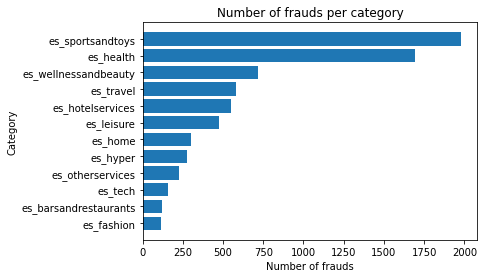

In [18]:
# Fraud analysis by Category
fraud_per_cat=is_fraud.groupby('category')['fraud'].agg(sum).sort_values()
fraud_per_cat=fraud_per_cat.reset_index()
plt.figure(1,figsize=(6,4))
plt.barh(fraud_per_cat['category'],fraud_per_cat['fraud'])
plt.title('Number of frauds per category')
plt.ylabel('Category')
plt.xlabel('Number of frauds')
plt.show()


# Feature Engineering

In [19]:
# new_list={'values':['F','M','M','M','M','M','F','F','F','M','U','E']}

# new_data=pd.DataFrame(new_list)
# condition1=new_data['values']=='U'
# condition2=new_data['values']=='E'
# new_data.drop(new_data[condition1].index,axis=0,inplace=True)
# new_data.drop(new_data[condition2].index,axis=0,inplace=True)
# new_data.head()

In [20]:


# mapping={'F':1,'M':0}
# new_data['values']=new_data['values'].map(mapping)
# new_data['values'].head()








In [21]:
fraud_df.head()


,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151',4,0,'M348934600',es_transportation,4.55,0
1,0,'C352968107',2,0,'M348934600',es_transportation,39.68,0
2,0,'C2054744914',4,1,'M1823072687',es_transportation,26.89,0
3,0,'C1760612790',3,0,'M348934600',es_transportation,17.25,0
4,0,'C757503768',5,0,'M348934600',es_transportation,35.72,0


In [22]:
#dropped irrelevant features
fraud_df=fraud_df.drop(['customer','merchant'],axis=1,inplace=False)
fraud_df.head()

,step,age,gender,category,amount,fraud
0,0,4,0,es_transportation,4.55,0
1,0,2,0,es_transportation,39.68,0
2,0,4,1,es_transportation,26.89,0
3,0,3,0,es_transportation,17.25,0
4,0,5,0,es_transportation,35.72,0


In [23]:
# perform one-hot enconding for categories 
fraud_df=pd.get_dummies(fraud_df,columns=['category'])
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592950 entries, 0 to 594642
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   step                            592950 non-null  int64  
 1   age                             592950 non-null  object 
 2   gender                          592950 non-null  int64  
 3   amount                          592950 non-null  float64
 4   fraud                           592950 non-null  int64  
 5   category_es_barsandrestaurants  592950 non-null  uint8  
 6   category_es_contents            592950 non-null  uint8  
 7   category_es_fashion             592950 non-null  uint8  
 8   category_es_food                592950 non-null  uint8  
 9   category_es_health              592950 non-null  uint8  
 10  category_es_home                592950 non-null  uint8  
 11  category_es_hotelservices       592950 non-null  uint8  
 12  category_es_hype

In [24]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592950 entries, 0 to 594642
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   step                            592950 non-null  int64  
 1   age                             592950 non-null  object 
 2   gender                          592950 non-null  int64  
 3   amount                          592950 non-null  float64
 4   fraud                           592950 non-null  int64  
 5   category_es_barsandrestaurants  592950 non-null  uint8  
 6   category_es_contents            592950 non-null  uint8  
 7   category_es_fashion             592950 non-null  uint8  
 8   category_es_food                592950 non-null  uint8  
 9   category_es_health              592950 non-null  uint8  
 10  category_es_home                592950 non-null  uint8  
 11  category_es_hotelservices       592950 non-null  uint8  
 12  category_es_hype

In [25]:

non_fraud_data=fraud_df[fraud_df['fraud']==0]
non_fraud_data['fraud'].value_counts()



0    585757
Name: fraud, dtype: int64

In [26]:

# selecting samples from the non fraud data , to decrease the difference between fraud and non fraud transaction numbers
# choosing random state to make sure we select the same data everytime 
#we selected 64800/585757 to give the ratio 1:9 (fraud:nonFraud) data 

sample_non_fraud=non_fraud_data.sample(frac=(64800/585757),random_state=15)
sample_non_fraud.head()

,step,age,gender,amount,fraud,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
6696,2,1,1,12.93,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
52395,20,3,0,142.48,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
458187,143,3,0,33.79,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
488570,151,3,1,23.22,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
315191,103,3,1,3.64,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
# concatenating the sampled data frame to the fraud dataframe 
#the outcome will be a new dataframe with ratio 1:9 (fraud:nonFraud) data 
fraud_data=fraud_df[fraud_df['fraud']==1]
combined_fraud_df=pd.concat([fraud_data,sample_non_fraud])
combined_fraud_df.head()

,step,age,gender,amount,fraud,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
88,0,3,0,44.26,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
89,0,3,0,324.50,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
434,0,3,0,176.32,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
435,0,3,0,337.41,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
553,0,4,1,220.11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [28]:
#since concatenate will add the second dataframe at the bottom
#we are using permutation to shuffle the data in the dataframe
combined_fraud_df=combined_fraud_df.iloc[np.random.permutation(len(combined_fraud_df['fraud']))]
combined_fraud_df.shape

(71993, 20)

In [29]:

# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

In [30]:
#(data – np. min(data)) / (np. max(data) – np. min(data)
combined_fraud_df['age']=combined_fraud_df['age'].astype(int)
combined_fraud_df['amount']=(combined_fraud_df['amount']-np.min(combined_fraud_df['amount']))/(np.max(combined_fraud_df['amount'])-np.min(combined_fraud_df['amount']))
combined_fraud_df['step']=(combined_fraud_df['step']-np.min(combined_fraud_df['step']))/(np.max(combined_fraud_df['step'])-np.min(combined_fraud_df['step']))
combined_fraud_df['age']=(combined_fraud_df['age']-np.min(combined_fraud_df['age']))/(np.max(combined_fraud_df['age'])-np.min(combined_fraud_df['age']))
combined_fraud_df.head()


,step,age,gender,amount,fraud,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
158833,0.307263,0.166667,1,0.018718,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
466438,0.810056,1.000000,1,0.003798,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
381731,0.675978,0.500000,0,0.000561,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
570780,0.966480,0.333333,0,0.006571,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
575165,0.972067,0.666667,0,0.000261,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [31]:
# (4) Choose the label and features
features_df=combined_fraud_df.drop('fraud',axis=1,inplace=False)
label_df=combined_fraud_df['fraud']
trainF,testF,trainL,testL=train_test_split(features_df,label_df,train_size=0.6,random_state=25)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71993 entries, 158833 to 93729
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   step                            71993 non-null  float64
 1   age                             71993 non-null  float64
 2   gender                          71993 non-null  int64  
 3   amount                          71993 non-null  float64
 4   category_es_barsandrestaurants  71993 non-null  uint8  
 5   category_es_contents            71993 non-null  uint8  
 6   category_es_fashion             71993 non-null  uint8  
 7   category_es_food                71993 non-null  uint8  
 8   category_es_health              71993 non-null  uint8  
 9   category_es_home                71993 non-null  uint8  
 10  category_es_hotelservices       71993 non-null  uint8  
 11  category_es_hyper               71993 non-null  uint8  
 12  category_es_leisure        

In [32]:
model_dl=Sequential()
# Input Layer
model_dl.add(
    Dense(50, input_dim=19, activation='relu')
)

# Hidden Layers
model_dl.add(
    Dense(100, activation='relu')
)
model_dl.add(
    Dense(50,activation='relu')
)

# Output Layer
model_dl.add(
    Dense(1,activation='linear')
)

In [49]:
model_dl.compile(
    metrics='accuracy',
    optimizer='adam',
    loss='binary_crossentropy'
)

In [50]:
model_dl.fit(trainF,trainL,epochs=50,shuffle=True,verbose=2)

Epoch 1/50
1350/1350 - 3s - loss: 0.0719 - accuracy: 0.9730 - 3s/epoch - 2ms/step
Epoch 2/50
1350/1350 - 2s - loss: 0.0683 - accuracy: 0.9738 - 2s/epoch - 2ms/step
Epoch 3/50
1350/1350 - 2s - loss: 0.0674 - accuracy: 0.9726 - 2s/epoch - 2ms/step
Epoch 4/50
1350/1350 - 2s - loss: 0.0705 - accuracy: 0.9717 - 2s/epoch - 2ms/step
Epoch 5/50
1350/1350 - 2s - loss: 0.0701 - accuracy: 0.9706 - 2s/epoch - 2ms/step
Epoch 6/50
1350/1350 - 2s - loss: 0.0683 - accuracy: 0.9741 - 2s/epoch - 2ms/step
Epoch 7/50
1350/1350 - 2s - loss: 0.0652 - accuracy: 0.9739 - 2s/epoch - 2ms/step
Epoch 8/50
1350/1350 - 2s - loss: 0.0666 - accuracy: 0.9736 - 2s/epoch - 2ms/step
Epoch 9/50
1350/1350 - 2s - loss: 0.0680 - accuracy: 0.9720 - 2s/epoch - 2ms/step
Epoch 10/50
1350/1350 - 2s - loss: 0.0702 - accuracy: 0.9698 - 2s/epoch - 2ms/step
Epoch 11/50
1350/1350 - 2s - loss: 0.0652 - accuracy: 0.9736 - 2s/epoch - 2ms/step
Epoch 12/50
1350/1350 - 2s - loss: 0.0801 - accuracy: 0.9721 - 2s/epoch - 2ms/step
Epoch 13/50
1

In [52]:
bc_train_loss,bc_train_accuracy=model_dl.evaluate(trainF,trainL,verbose=0
                           )
print('BC Train:', bc_train_loss,bc_train_accuracy)

BC Train: 0.06305167824029922 0.9739784598350525


In [53]:
bc_test_loss,bc_test_accuracy=model_dl.evaluate(testF,testL,verbose=0)
                        
print('BC Test:', bc_test_loss,bc_test_accuracy)

BC Test: 0.06947989016771317 0.9751718640327454


In [37]:
# (6) Confirm data is ready with further exploratory analysis

In [38]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [39]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [40]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [41]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [42]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [43]:
# (11) Use the model for prediction

In [44]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)